**Link of the dataset:** https://www.kaggle.com/datasets/humairmunir/gender-recognizer  <br>
**Note:** This notebook will not work without the mentioned dataset

## Importing Libraries

In [173]:
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms, models, datasets
from tqdm.notebook import tqdm
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Preprocessing Data

**There are few problems with the dataset**
* The dataset is not spplit into 'train' 'val' directory
* Another problem is that in the 'WOMAN' directory there is a 'MEN' folder which contains more images of man

In [155]:
def get_dataset():
    man_path = '/kaggle/input/gender-recognizer/dataset/MEN'
    woman_path = '/kaggle/input/gender-recognizer/dataset/WOMAN'
    man_path_2 = '/kaggle/input/gender-recognizer/dataset/WOMAN/MEN'
    
    dir_paths = [man_path, woman_path, man_path_2]
    image_paths = []
    labels = []
    
    for dir_path in dir_paths:
        dir_path = list(Path(dir_path).glob('*.jpg'))  # For my future self: .glob("*/*.jpg")) also can use like this
        for img_path in dir_path:
            image_paths.append(img_path)
            labels.append(img_path.parent.stem)
            
    return pd.DataFrame({'image_path': image_paths, 'label': labels})

In [156]:
data = get_dataset()

In [157]:
data

,image_path,label
0,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
1,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
2,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
3,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
4,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
...,...,...
1836,/kaggle/input/gender-recognizer/dataset/WOMAN/...,MEN
1837,/kaggle/input/gender-recognizer/dataset/WOMAN/...,MEN
1838,/kaggle/input/gender-recognizer/dataset/WOMAN/...,MEN
1839,/kaggle/input/gender-recognizer/dataset/WOMAN/...,MEN


In [158]:
data.label.unique()

array(['MEN', 'WOMAN'], dtype=object)

## Load Dataset

In [159]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize should always be last
]) 

In [160]:
class GenderDataset(Dataset):
    def __init__(self, df, transform=transform):
        super().__init__()
        self.df = df
        self.transform = transform
        
    def __len__(self): return len(self.df)
    
    def load_image(self, ix):
        img_path = self.df.iloc[ix].image_path
        return Image.open(img_path), self.df.iloc[ix].label
    
    def __getitem__(self, ix):
        img, label = self.load_image(ix)
        gender = float(label == 'WOMAN')  # 'MEN -> 0' 'WOMAN -> 1'
        return self.transform(img), gender

In [161]:
gender_ds = GenderDataset(data, transform)

MEN


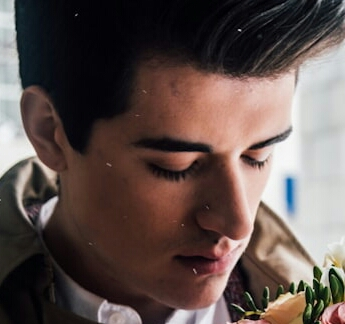

In [162]:
im, label = gender_ds.load_image(5)
print(label)
im

In [163]:
gender_ds[5]

(tensor([[[ 0.9474,  0.9303,  0.8447,  ..., -1.1247,  0.0056,  0.8789],
          [ 0.9646,  0.9474,  0.8618,  ..., -0.9363,  0.3994,  0.9303],
          [ 0.9817,  0.9303,  0.8618,  ..., -0.7137,  0.2967,  0.7248],
          ...,
          [-1.6898, -1.7069, -1.7240,  ...,  0.7591,  0.9817,  1.3070],
          [-1.6898, -1.6898, -1.7069,  ...,  0.3309,  0.5022,  0.4851],
          [-1.6898, -1.6898, -1.6898,  ..., -0.0629,  0.1083, -0.3198]],
 
         [[ 1.3081,  1.2906,  1.2031,  ..., -0.8978,  0.2752,  1.1155],
          [ 1.3256,  1.3081,  1.2206,  ..., -0.6877,  0.6429,  1.1681],
          [ 1.3431,  1.2906,  1.2206,  ..., -0.4951,  0.5203,  0.9405],
          ...,
          [-1.6506, -1.6681, -1.6856,  ..., -0.4601, -0.1450,  0.3102],
          [-1.6506, -1.6506, -1.6681,  ..., -0.8803, -0.6702, -0.6001],
          [-1.6506, -1.6506, -1.6506,  ..., -1.1954, -1.0903, -1.4755]],
 
         [[ 1.5245,  1.5071,  1.4200,  ..., -0.5495,  0.6182,  1.4722],
          [ 1.5420,  1.5245,

## Split data

In [164]:
train_ds, valid_ds, test_ds = random_split(gender_ds, [0.8, 0.1, 0.1])

In [165]:
len(train_ds), len(valid_ds), len(test_ds)

(1473, 184, 184)

## Dataloader

In [166]:
BATCH_SIZE = 32
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [167]:
len(train_dl), len(valid_dl), len(test_dl)

(47, 6, 6)

## Define Model

In [190]:
def get_resnet18():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
        
    model.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(512, 128),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(128, 1),
                            nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    
    return model.to(device), loss_fn, optimizer 

In [191]:
model, loss_fn, optimizer = get_resnet18()

## Train Model

In [192]:
def train_batch(data, model, optimizer, criterion):
    model.train()
    img, gender = data
    optimizer.zero_grad()
    pred_gender = model(img.to(device))
    loss = criterion(torch.flatten(pred_gender), gender.float().to(device))
    loss.backward()
    optimizer.step()
    
    return loss

@torch.no_grad()
def validate_batch(data, model, criterion):
    model.eval()
    img, gender = data
    pred_gender = model(img.to(device))
    loss = criterion(torch.flatten(pred_gender), gender.float().to(device))
    return pred_gender, loss

In [193]:
train_loss, valid_loss = [], []
epochs = 10

for epoch in range(epochs):
    print(f"epoch {epoch + 1}/{epochs}")
    epoch_train_loss, epoch_valid_loss = 0, 0
    
    for batch in tqdm(train_dl, desc='training loop'):
        img , gender = batch
        loss = train_batch(batch, model, optimizer, loss_fn)
        epoch_train_loss += loss.item()
    epoch_train_loss /= len(img)
    
    for batch in tqdm(valid_dl, desc='validation loop'):
        img , gender = batch
        pred_gender, loss = validate_batch(batch, model, loss_fn)
        epoch_valid_loss += loss.item()
    epoch_valid_loss /= len(img)
    
    train_loss.append(epoch_train_loss)
    valid_loss.append(epoch_valid_loss)
    print('Training loss: {:.2f}'.format(np.mean(train_loss)))
    print('Validation loss: {:.2f}'.format(np.mean(valid_loss)))
    print('='*30)

epoch 1/10


training loop:   0%|          | 0/47 [00:00<?, ?it/s]

validation loop:   0%|          | 0/6 [00:00<?, ?it/s]

Training loss: 20.84
Validation loss: 0.04
epoch 2/10


training loop:   0%|          | 0/47 [00:00<?, ?it/s]

validation loop:   0%|          | 0/6 [00:00<?, ?it/s]

Training loss: 15.77
Validation loss: 0.03
epoch 3/10


training loop:   0%|          | 0/47 [00:00<?, ?it/s]

validation loop:   0%|          | 0/6 [00:00<?, ?it/s]

Training loss: 13.12
Validation loss: 0.03
epoch 4/10


training loop:   0%|          | 0/47 [00:00<?, ?it/s]

validation loop:   0%|          | 0/6 [00:00<?, ?it/s]

Training loss: 11.70
Validation loss: 0.03
epoch 5/10


training loop:   0%|          | 0/47 [00:00<?, ?it/s]

validation loop:   0%|          | 0/6 [00:00<?, ?it/s]

Training loss: 10.84
Validation loss: 0.03
epoch 6/10


training loop:   0%|          | 0/47 [00:00<?, ?it/s]

validation loop:   0%|          | 0/6 [00:00<?, ?it/s]

Training loss: 10.18
Validation loss: 0.03
epoch 7/10


training loop:   0%|          | 0/47 [00:00<?, ?it/s]

validation loop:   0%|          | 0/6 [00:00<?, ?it/s]

Training loss: 9.71
Validation loss: 0.03
epoch 8/10


training loop:   0%|          | 0/47 [00:00<?, ?it/s]

validation loop:   0%|          | 0/6 [00:00<?, ?it/s]

Training loss: 9.22
Validation loss: 0.03
epoch 9/10


training loop:   0%|          | 0/47 [00:00<?, ?it/s]

validation loop:   0%|          | 0/6 [00:00<?, ?it/s]

Training loss: 8.91
Validation loss: 0.03
epoch 10/10


training loop:   0%|          | 0/47 [00:00<?, ?it/s]

validation loop:   0%|          | 0/6 [00:00<?, ?it/s]

Training loss: 8.67
Validation loss: 0.03


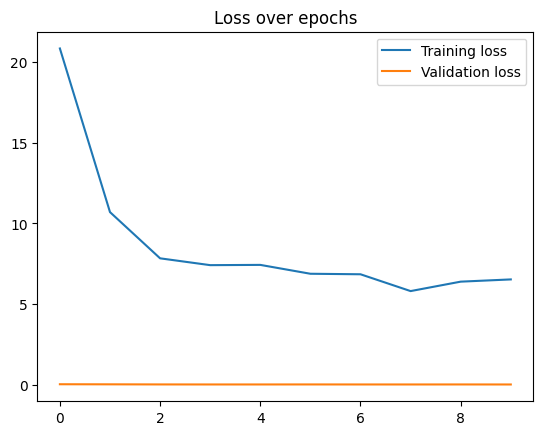

In [194]:
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

## Accuracy on Testing data

In [232]:
@torch.no_grad()
def model_accuracy(data, model):
    model.eval()
    img, gender = data
    pred_gender = model(img.to(device))
    pred_gender = pred_gender.cpu().detach().numpy()
    pred_gender = np.round_(pred_gender)
    gender = gender.cpu().detach().numpy()
    corr_pred = [1 if p == g else 0 for p, g in zip(pred_gender, gender)]
    acc = (sum(corr_pred) / len(img))*100
    print('Accuracy: {:.2f}%, Correct predcition: {}/{}'.format(acc, sum(corr_pred), len(img)))
    return acc

In [233]:
accuracy = 0
for batch in tqdm(test_dl, desc='testing loop'):
    accuracy += model_accuracy(batch, model)
print('Overall accuracy: {:.2f}%'.format(accuracy/len(test_dl)))

testing loop:   0%|          | 0/6 [00:00<?, ?it/s]

Accuracy: 93.75%, Correct predcition: 30/32
Accuracy: 100.00%, Correct predcition: 32/32
Accuracy: 96.88%, Correct predcition: 31/32
Accuracy: 96.88%, Correct predcition: 31/32
Accuracy: 96.88%, Correct predcition: 31/32
Accuracy: 100.00%, Correct predcition: 24/24
Overall accuracy: 97.40%
